In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

In [2]:
def normalize(random_variable):
    max_value = max(random_variable)
    min_value = min(random_variable)
    return [(x - min_value)/(max_value - min_value) for x in random_variable]

def rolling_average(buffer, k):
    avg = []
    for i in range(0, len(buffer) - k, k):
        cur_avg = sum(buffer[i:i+k]) / k
        for j in range(k):
            avg.append(cur_avg)
    return normalize(avg)

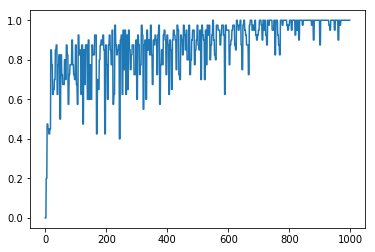

[['↓' '↗' '*']
 ['↗' '↗' '↑']
 ['↗' '↑' '→']]


In [3]:
class Grid():
    def __init__(self):
        self.state = None
        
    def reset(self):
        self.state = (2, 0)
        return self.state
        
    def step(self, action):
        # print(action)
        row_step = action[0]
        col_step = action[1]
        row = max(0, min(2, self.state[0] + row_step))
        col = max(0, min(2, self.state[1] + col_step))
        if (row, col) == (0, 2):
            reward = 0
            terminal = True
        else:
            reward = -1
            terminal = False
        self.state = (row, col)
        return (row, col), reward, terminal

class AgentQ():
    def __init__(self):
        self.gamma = 0.99
        self.alpha = 0.01
        self.q_table = np.zeros((9, 8))
        self.actions = [(a, b) for a in range(-1, 2) 
                                for b in range(-1, 2) 
                                 if (a,b) != (0,0)]
        self.exp_rate = 1
        self.decay = 0.99
    
    def act(self, state):
        if random.random() < self.exp_rate:
            action_id = random.randint(0, 7)
        else:
            state = state[0]*3 + state[1]
            action_id = np.random.choice(np.flatnonzero(self.q_table[state] == self.q_table[state].max()))
        
        self.exp_rate *= self.decay
        
        return action_id, self.actions[action_id]
    
    def q_update(self, state, action_id, reward, next_state, terminal):
        state = state[0]*3 + state[1]
        next_state = next_state[0]*3 + next_state[1]
        if terminal:
            target = reward
        else:
            target = reward + self.gamma*max(self.q_table[next_state])
        
        td_error = target - self.q_table[state, action_id]
        self.q_table[state, action_id] = self.q_table[state, action_id] + self.alpha*td_error
    
    def translate_action(self, action):
        if action == (-1, -1):
            return "↖"
        if action == (0, -1):
            return "←"
        if action == (1, -1):
            return "↙"
        if action == (1, 0):
            return "↓"
        if action == (1, 1):
            return "↘"
        if action == (0, 1):
            return "→"
        if action == (-1, 1):
            return "↗"
        if action == (-1, 0):
            return "↑"
    
    def best_policy(self):
        policy = np.zeros((3, 3), dtype='<U5')
        states = [(i,j) for i in range(3) for j in range(3)]
        for s in states:
            state = s[0]*3 + s[1]
            if s == (0, 2):
                policy[s] = "*"
            else:
                action_id = np.argmax(self.q_table[state])
                action = self.actions[action_id]
                policy[s] = self.translate_action(action)
        return policy

        
def train_agent():
    num_episodes = 1000
    agent = AgentQ()
    env = Grid()
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            action_id, action = agent.act(state)
            next_state, reward, terminal = env.step(action)
            episode_reward += reward
            
            agent.q_update(state, action_id, reward, next_state, terminal)
            state = next_state
            
            if terminal:
                break
        rewards.append(episode_reward)
    
    k = 3
    reward_plot = rolling_average(rewards, k)
    plt.plot(reward_plot)
    plt.show()
    
    return agent.best_policy()
print(train_agent())

[['↗' '↗' '*']
 ['↘' '↗' '↑']
 ['↗' '↓' '↓']]


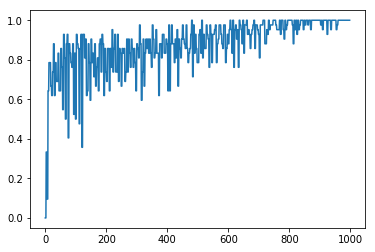

In [4]:
import copy 

class AgentQ():
    def __init__(self):
        self.gamma = 0.99
        self.alpha = 0.01
        self.q_table = np.zeros((9, 8))
        self.q_target = np.zeros((9, 8))
        self.actions = [(a, b) for a in range(-1, 2) 
                                for b in range(-1, 2) 
                                 if (a,b) != (0,0)]
        self.exp_rate = 1
        self.decay = 0.99
        self.copy_steps = 10
    
    def act(self, state):
        if random.random() < self.exp_rate:
            action_id = random.randint(0, 7)
        else:
            state = state[0]*3 + state[1]
            action_id = np.random.choice(np.flatnonzero(self.q_table[state] == self.q_table[state].max()))
        
        self.exp_rate *= self.decay
        
        return action_id, self.actions[action_id]
    
    def q_update(self, state, action_id, reward, next_state, terminal):
        state = state[0]*3 + state[1]
        next_state = next_state[0]*3 + next_state[1]
        if terminal:
            target = reward
        else:
            target = reward + self.gamma*max(self.q_target[next_state])
        
        td_error = target - self.q_table[state, action_id]
        self.q_table[state, action_id] = self.q_table[state, action_id] + self.alpha*td_error
    
    def copy(self):
        self.q_target = copy.deepcopy(self.q_table)
    
    def translate_action(self, action):
        if action == (-1, -1):
            return "↖"
        if action == (0, -1):
            return "←"
        if action == (1, -1):
            return "↙"
        if action == (1, 0):
            return "↓"
        if action == (1, 1):
            return "↘"
        if action == (0, 1):
            return "→"
        if action == (-1, 1):
            return "↗"
        if action == (-1, 0):
            return "↑"
    
    def best_policy(self):
        policy = np.zeros((3, 3), dtype='<U5')
        states = [(i,j) for i in range(3) for j in range(3)]
        for s in states:
            state = s[0]*3 + s[1]
            if s == (0, 2):
                policy[s] = "*"
            else:
                action_id = np.argmax(self.q_table[state])
                action = self.actions[action_id]
                policy[s] = self.translate_action(action)
        return policy
            
        
def train_agent_doubleq():
    num_episodes = 1000
    agent = AgentQ()
    env = Grid()
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        num_steps = 0
        while True:
            action_id, action = agent.act(state)
            next_state, reward, terminal = env.step(action)
            
            num_steps += 1
            if num_steps % agent.copy_steps == 0:
                agent.copy()
            
            episode_reward += reward
            
            agent.q_update(state, action_id, reward, next_state, terminal)
            state = next_state
            
            if terminal:
                break
            
        rewards.append(episode_reward)
    
    k = 3
    reward_plot = rolling_average(rewards, k)
    plt.plot(reward_plot)
    
    return agent.best_policy()
print(train_agent_doubleq())